In [2]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import deepRD.tools.trajectoryTools as trajectoryTools
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [3]:
d1=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0001"))
d2=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0002"))
d3=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0003"))
# time, position (3d), velocity (3d), states (1d), r_aux(3d)
dataset = torch.cat((d1, d2, d3), dim=0)
dataset=d1
dataset.shape

torch.Size([10000, 11])

In [4]:
# Reform data for input
r_aux = dataset[:, -3:]
r_v = dataset[:, 1:7]
# Input: R_aux (3), condition: position, velocity (6)
data = torch.utils.data.TensorDataset(r_aux, r_v)

In [5]:
class VarAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3+6, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3+6, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            #nn.Sigmoid()
        )
        self.linear1 = nn.Linear(20, 3)
        self.linear2 = nn.Linear(20, 3)
        self.G = torch.distributions.Normal(0, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std*self.G.sample(mu.shape)

    def sample(self, label):
        z = torch.randn(3)
        z_cond = torch.cat((z, label))
        return self.decoder(z_cond)

    def forward(self, x, y):
        x_cond = torch.cat((x,y), dim=1)
        x = self.encoder(x_cond)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        z = self.reparametrize(mu, logvar)
        z_cond = torch.cat((z, y), dim=1)
        output = self.decoder(z_cond)
        return output, mu, logvar

#VAE = VarAutoencoder()

In [6]:
learning_rate = 1e-5
batch_size = 32

In [7]:
loss_1 = nn.MSELoss()
def loss_2(mu, logvar):
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar), dim = 1), dim = 0).sum()

In [8]:
#optimizer = torch.optim.SGD(ae.parameters(), lr=learning_rate, momentum=momentum)

data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [9]:
x1, l1 = next(iter(data_loader))
print(x1.shape, l1.shape)

torch.Size([32, 3]) torch.Size([32, 6])


In [29]:
# Training loop
epochs = 30
losses = []
beta1_vals = [10, 100, 1000]
beta2_vals = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
for beta1 in beta1_vals:
    for beta2 in beta2_vals:
        VAE = VarAutoencoder()
        optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-9)
        print(beta1, beta2)
        for epoch in range(epochs):
            plot = True
            VAE.train()
            for (image, label) in data_loader:

                # Feed through the network
                reconstruction, mu, logvar = VAE(image, label)
                # Calculate loss function
                loss = beta1*loss_1(reconstruction, image) + beta2*loss_2(mu, logvar)
                losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if plot==True and epoch==epochs-1:
                    avg_diff=0
                    print('Epoch ', epoch+1)
                    with torch.no_grad():
                        print('loss1', loss_1(reconstruction, image), 'loss2', loss_2(mu, logvar))
                        indices = numpy.random.choice(32, 4)
                        print(indices)
                        for i, ind in enumerate(indices):
                            sampled = VAE.sample(label[ind])
                            print(f'I:{image[ind]}, R:{reconstruction[ind].detach()}, G:{sampled}') 
                            avg_diff += torch.norm(image[ind]-sampled)
                            #print(f'D:{image[ind]-sampled}')
                            # Lb:{label[ind]}, La:{mu[ind]}, {numpy.exp(logvar[ind])}, R:{reconstruction[ind]},
                    avg_diff /= len(indices)
                    print(avg_diff)
                    plt.show()
                    print(losses[-1])
                    plot=False        

10 0
Epoch  30
loss1 tensor(7.3519e-05) loss2 tensor(0.0693)
[ 7  4 29 20]
I:tensor([-0.0042, -0.0012,  0.0036]), R:tensor([0.0013, 0.0008, 0.0003]), G:tensor([-0.0003, -0.0005,  0.0011])
I:tensor([-0.0011,  0.0047, -0.0035]), R:tensor([ 3.6202e-05, -2.9032e-04,  2.5004e-04]), G:tensor([ 0.0004, -0.0003,  0.0005])
I:tensor([ 0.0078,  0.0035, -0.0064]), R:tensor([-0.0007, -0.0008, -0.0019]), G:tensor([-5.7448e-05, -9.8406e-04, -1.9131e-03])
I:tensor([-0.0040,  0.0006, -0.0008]), R:tensor([ 9.3490e-04,  3.8145e-05, -2.3554e-03]), G:tensor([ 1.1399e-03, -7.8502e-04,  5.7172e-05])
tensor(0.0067)
0.000735191279090941
10 1e-06
Epoch  30
loss1 tensor(0.0003) loss2 tensor(0.0709)
[14  3 21  5]
I:tensor([-0.0043, -0.0090, -0.0006]), R:tensor([-0.0022, -0.0024,  0.0039]), G:tensor([-0.0021, -0.0021,  0.0059])
I:tensor([0.0025, 0.0314, 0.0037]), R:tensor([ 0.0004,  0.0024, -0.0022]), G:tensor([ 0.0005,  0.0012, -0.0019])
I:tensor([-0.0020,  0.0079, -0.0288]), R:tensor([-0.0002, -0.0005, -0.0001])

In [10]:
VAE = VarAutoencoder()
optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-8)
learning_rate = 1e-7
batch_size = 32
beta1 = 10
beta2 = 0.0001

In [11]:
epochs = 30
losses = []
r_norms=None
r_new = None
for epoch in range(epochs):
    VAE.train()
    for (image, label) in data_loader:

        # Feed through the network
        reconstruction, mu, logvar = VAE(image, label)
        # Calculate loss function
        loss = beta1*loss_1(reconstruction, image) + beta2*loss_2(mu, logvar)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if epoch==epochs-1:
                norms = torch.cat( (torch.norm(image, dim=1).unsqueeze(0), torch.norm(reconstruction, dim=1).unsqueeze(0)) , dim=0)
                if r_norms is None:
                    r_norms = norms
                    r_new = reconstruction
                else:
                    r_norms = torch.cat((r_norms, norms), dim=1)
                    r_new = torch.cat( (r_new, reconstruction), dim=0)
    print(losses[-1])


0.00964087713509798
0.002297067316249013
0.0030653474386781454
0.0034393249079585075
0.003854591166600585
0.0033114675898104906
0.002112066140398383
0.004045927431434393
0.001097117899917066
0.00185749726369977
0.0007455101003870368
0.0012912419624626637
0.0011014670599251986
0.008345245383679867
0.002518938621506095
0.0042558941058814526
0.0013804723275825381
0.0036327182315289974
0.0018377613741904497
0.0011474046623334289
0.0006312119076028466
0.0018036420224234462
0.0006715789204463363
0.002142544835805893
0.0035942411050200462
0.002552420599386096
0.0037583678495138884
0.001240994082763791
0.002099101897329092
0.003716668114066124


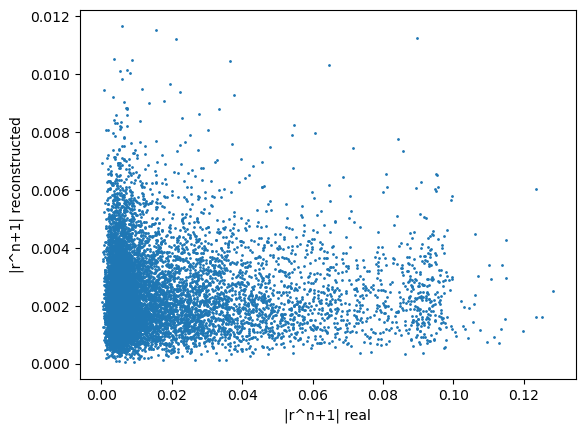

In [12]:
r_ns = r_norms.clone().detach()
plt.scatter(r_ns[0], r_ns[1], s=1)
plt.xlabel('|r^n+1| real')
plt.ylabel('|r^n+1| reconstructed')
#plt.gca().set_aspect('equal')
plt.show()

tensor([[-0.0051, -0.0105, -0.0113],
        [-0.0117, -0.0048,  0.0076],
        [-0.0024,  0.0068,  0.0205]])
tensor([[-0.0117, -0.0048,  0.0076],
        [-0.0024,  0.0068,  0.0205],
        [-0.0042,  0.0036,  0.0133]]) tensor([0.1222, 0.1117, 0.1104,  ..., 0.0896, 0.0907, 0.0901])


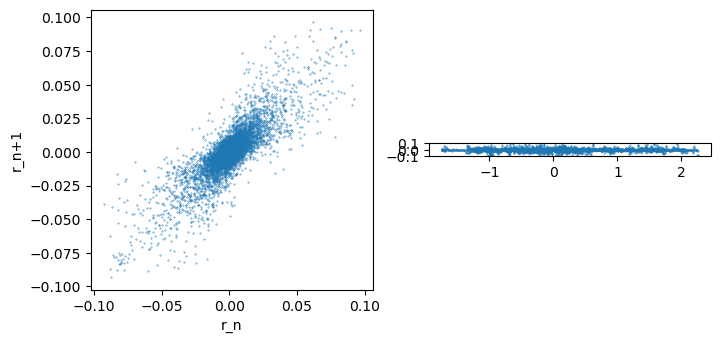

In [13]:
r_n = r_aux
r_np1 = torch.roll(r_aux, -1, 0)
v = r_v[:, 3:]
r = r_v[:, :3]
print(r_n[:3])
print(r_np1[:3], v[:-1, 0])
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(r_n[:, 2], r_np1[:,2], s=0.1)
ax1.set_xlabel('r_n')
ax1.set_ylabel('r_n+1')
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(r[:,2], r_np1[:, 2], s=0.1)
plt.gca().set_aspect('equal')

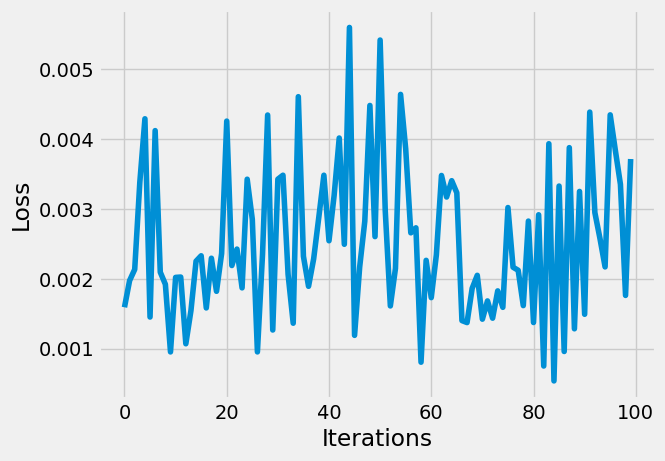

In [14]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# Plotting the last 100 values
plt.plot(losses[-100:])